# imports

In [40]:
# ==========================
# 1. 標準庫
# ==========================
import sys
import os
import io
import json
import glob
import datetime
import random
from pathlib import Path
from typing import Dict, List, Union, Callable, Optional, Tuple

# ==========================
# 2. 第三方套件
# ==========================
import numpy as np
import xarray as xr
import matplotlib.pylab as plt
from tqdm import trange
from IPython.display import clear_output, display, HTML
from scipy.ndimage import generic_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as Optimizer
from torchsummary import summary

# import cv2  # 如果影片相關再啟用

# ==========================
# 3. 專案設定
# ==========================
project_root = "C:/Users/GAI/Desktop/Scott/NCA_Research"
if project_root not in sys.path:
    sys.path.append(project_root)

# ==========================
# 4. IPython 魔法指令 (Jupyter 專用)
# ==========================
%reload_ext autoreload
%autoreload 2

# ==========================
# 5. 專案自定義函式庫
# ==========================
from core_utils.plotting import (
    plt_HWC_split_channels,
    plt_CFD_channels,
    plt_random_cfd_slice
)


# from core_utils.utils_io import (
#     np2pil,      # numpy → PIL Image
#     imwrite,     # 儲存圖像為檔案
#     imencode,    # 編碼圖像為 byte stream
#     im2url,      # 圖像轉 base64 URL（HTML 顯示用）
#     load_emoji,   # 載入 emoji 圖像
#     load_cfd_npy
# )

# from core_utils.utils_image import (
#     imshow,      # 在 notebook 顯示圖像
#     tile2d,      # 多圖拼接
#     zoom         # 放大圖像
# )

# from core_utils.utils_video import (
#     save_video,  # 批次輸出影片
#     VideoWriter  # 逐幀寫入影片（支援 context manager）
# )

# from core_utils.ops_tf_np import (
#     to_rgb,
#     to_rgba,
#     to_alpha,
#     crop_and_resize,
#     get_random_cfd_slices,
#     get_random_cfd_slices_pair
# )


from core_utils.viz_train import (
    viz_pool,
    viz_batch,
    viz_loss
)


# 6. 實驗項目 utils 函式庫導入
from E4_PI_NCA.utils.helper import (
    to_HWC,
    print_tensor_stats,
    split_cases


)

clear_output()

# process urbantales cases into npz file 

In [41]:
def nan_to_masked_CHW(CHW: np.ndarray) -> np.ndarray:
    """
    將 CHW 張量中的 NaN 補 0，並在 channel 維度上加一個 mask (C+1, H, W)
    Mask: 原本是 NaN 的位置為 0，其他位置為 1

    Parameters
    ----------
    CHW : np.ndarray
        shape = (C, H, W)

    Returns
    -------
    masked_CHW : np.ndarray
        shape = (C+1, H, W), 最後一個 channel 為 mask
    """
    # 生成 mask (原本非 NaN = 1, NaN = 0)
    mask = (~np.isnan(CHW)).astype(np.float32)

    # 補 0
    CHW_clean = np.nan_to_num(CHW, nan=0.0)

    # concat mask
    masked_CHW = np.concatenate([mask.mean(axis=0, keepdims=True),CHW_clean], axis=0)
    return masked_CHW

In [42]:
from pathlib import Path
import numpy as np
import xarray as xr

# 資料夾路徑
folder = Path("../dataset")

# 存放每個 case 最終 numpy array
case_dict = {}
# 存放每個 case channel 名稱
channel_name_dict = {}

# 遍歷所有 ped.nc 檔案
for ped_file in folder.rglob("*ped.nc"):
    case_name = ped_file.parent.name
    
    # 讀取 NetCDF
    with xr.open_dataset(ped_file) as ds:
        # 將所有變數堆疊成 3D array (H, W, C)
        arrays = [ds[var].values for var in ds.data_vars]
        ped_np = np.stack(arrays, axis=-1)

        # 變數名稱就是 channel 名稱
        channel_names = list(ds.data_vars.keys())

    
    # 對應 topo 檔案
    topo_file = ped_file.parent.glob("*_topo")
    topo_file = next(topo_file, None)
    if topo_file:
        topo = np.loadtxt(topo_file)[:, :, np.newaxis]  # (H, W, 1)
        ped_np = np.concatenate([ped_np, topo], axis=2)  # 合併 (H, W, C+1)
        channel_names.append("topo")  # topo 加入 channel name
        
    # (H, W, C)-> (C, H, W)
    ped_np = np.transpose(ped_np, (2, 0, 1))
    ped_np = nan_to_masked_CHW(ped_np)  # 補 NaN 並加 mask (C+1, H, W)
    ped_np = norm_CHW(ped_np)  # channel-wise 0-1 normalization
    channel_names.insert(0, "geo_mask")  # 將 topo mask 加到最前面    # 存入 dict
    case_dict[case_name] = ped_np
    channel_name_dict[case_name] = channel_names

# =========================
# 將整個 dict 存成 .npz 檔
# =========================
np.savez_compressed("../dataset/all_cases.npz", **case_dict)

print("所有 case 已存成 all_cases.npz")
example_case = next(iter(case_dict))
print("範例 case shape:", case_dict[example_case].shape)
print("範例 case channel names:", channel_name_dict[example_case])


所有 case 已存成 all_cases.npz
範例 case shape: (7, 576, 576)
範例 case channel names: ['geo_mask', 'uped', 'vped', 'Uped', 'TKEped', 'Tuwped', 'topo']


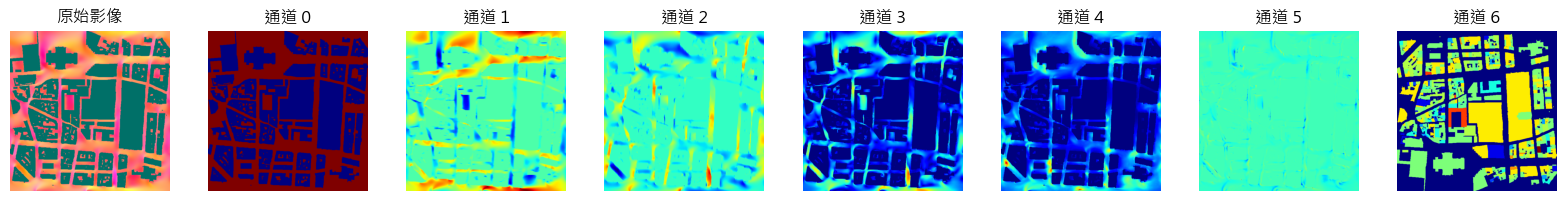

FR-PA-V2_d30 (C,H,W) shape = (7, 576, 576)
  channel 0: min=0.000000, max=1.000000
  channel 1: min=0.000000, max=1.000000
  channel 2: min=0.000000, max=1.000000
  channel 3: min=0.000000, max=1.000000
  channel 4: min=0.000000, max=1.000000
  channel 5: min=0.000000, max=1.000000
  channel 6: min=0.000000, max=1.000000
Has NaN: False
Has Inf: False




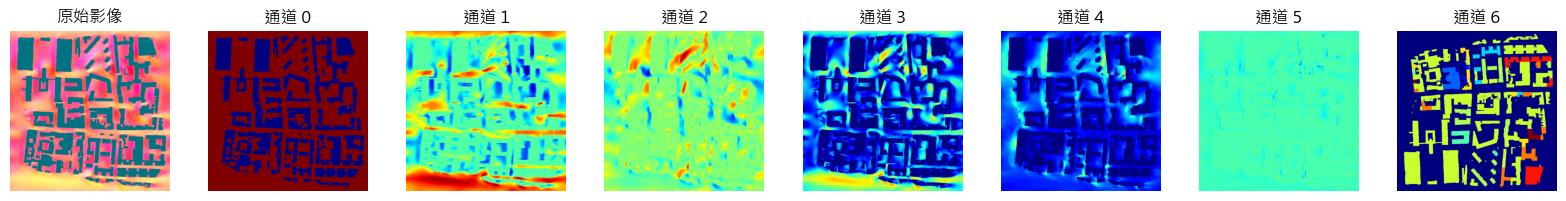

FR-PA-V1_d00 (C,H,W) shape = (7, 576, 576)
  channel 0: min=0.000000, max=1.000000
  channel 1: min=0.000000, max=1.000000
  channel 2: min=0.000000, max=1.000000
  channel 3: min=0.000000, max=1.000000
  channel 4: min=0.000000, max=1.000000
  channel 5: min=0.000000, max=1.000000
  channel 6: min=0.000000, max=1.000000
Has NaN: False
Has Inf: False




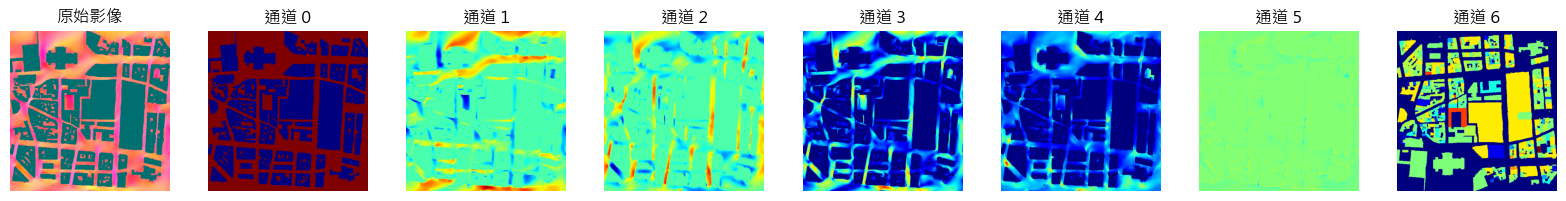

FR-PA-V2_d45 (C,H,W) shape = (7, 576, 576)
  channel 0: min=0.000000, max=1.000000
  channel 1: min=0.000000, max=1.000000
  channel 2: min=0.000000, max=1.000000
  channel 3: min=0.000000, max=1.000000
  channel 4: min=0.000000, max=1.000000
  channel 5: min=0.000000, max=1.000000
  channel 6: min=0.000000, max=1.000000
Has NaN: False
Has Inf: False


In [43]:
# 將 keys 轉成 list，再隨機選一個
for _ in range(3):
    print("\n")
    key = random.choice(list(case_dict.keys()))
    case = case_dict[key]
    plt_HWC_split_channels(to_HWC(case))
    print_tensor_stats(case, name=key)

    print("Has NaN:", np.isnan(to_HWC(case)).any())
    print("Has Inf:", np.isinf(to_HWC(case)).any())


